## On mice can’t hide their thoughts (a project for analyzing behavioral trajectories based on hippocampal activity)
- The brain generates an internal representaion of an animal's position through the spatially-tuned firing of hippocampal 'place cells'. While place cells typically signal the animal's current location, they can also express non-local activity patterns that sweep ahead of the animal toward possible left or right future paths.
- Goal: analyze the trajectories of mice navigating a Y-maze based on hippocampal sweep dynamics. Compare left turn trials with left sweeps with a left turn trials with right sweeps and discuss how to analyze the differences between them.
- Data: previously generated position decodes from the spiking of hippocampal CA1 place cells using Frank Lab algorithm (https://github.com/Eden-Kramer-Lab/replay_trajectory_classification/tree/master), and position information extracted from an overhead camera using DeepLabCut (https://github.com/DeepLabCut/DeepLabCut).

### Load functions and data

In [1]:
import sys, re
sys.path.append('D:\Ymaze\DATA') # path with Ymaze_Load_Curate.py (main script will all functions)
from Ymaze_Load_Curate import *
from scipy.interpolate import interp1d

# select local functions
def rotate_points(x, y, angle_degrees):
    
    # rotate points in 2d space, useful for rotating Y-maze to align with viewer
    angle_radians = np.radians(angle_degrees)
    points = np.column_stack((x, y))
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                 [np.sin(angle_radians),  np.cos(angle_radians)]])
    rotated_points = np.dot(points, rotation_matrix.T)
    return rotated_points[:, 0], rotated_points[:, 1]

def curate_beh_trials(x_coords, y_coords, turn_sweep_type):
    # remove behavioral trials, (and sweeps) that are longer than one std from mean
    # necessary for looking at average trajectories
    
    trial_lengths = [len(x_coords[i]) for i in range(0,len(x_coords))]
    upper = np.round(np.mean(trial_lengths) + np.std(trial_lengths)/2)
    x_coords_curated = [x_coords[i] for i in np.where(trial_lengths < upper)[0]]
    y_coords_curated = [y_coords[i] for i in np.where(trial_lengths < upper)[0]]
    turn_sweep_type_curated =  [turn_sweep_type[i] for i in np.where(trial_lengths < upper)[0]]
    return x_coords_curated, y_coords_curated, np.array(turn_sweep_type_curated)

def get_avg_trajectory(x_coords, y_coords):
    # get average trajectory of sets of points in 2D coordinates

    # get trajectories
    trajectories = [np.array([[x_coords[trial][i], y_coords[trial][i]] for i in range(0, len(x_coords[trial]))]) for trial in range(0,len(x_coords))]
    # Find the maximum length among all trajectories
    max_length = max(len(traj) for traj in trajectories)
    # Interpolate the trajectories to the maximum length
    interpolated_trajectories_x = []
    interpolated_trajectories_y = []
    for traj in trajectories:
        x = traj[:, 0]
        y = traj[:, 1]
        interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
        interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
        interpolated_trajectories_x.append(interpolated_traj_x)
        interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
        interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
        interpolated_trajectories_y.append(interpolated_traj_y)
    # Calculate the average trajectory
    average_trajectory_x = np.mean(interpolated_trajectories_x, axis=0)
    average_trajectory_y = np.mean(interpolated_trajectories_y, axis=0)
    return interpolated_trajectories_x, average_trajectory_x, interpolated_trajectories_y, average_trajectory_y

def get_rotated_traj(turn_sweep_type):
    # turn_sweep_type: #RTRS_id/RTLS_id, LTLS_id/LTRS_id, or intersect
    # returns rotated trajectories areound the center point of the maze (middle point of node_positions) based on input turn sweep type 

    def rotate_point(point, center, angle):
        # rotate a point around a given center
        # point is a tuple (x, y) representing the coordinates of the point to be rotated
        # center is a tuple (cx, cy) representing the coordinates of the point of rotation
        # angle is the angle in degrees by which the point is to be rotated counterclockwise
    
        # Translate the point and center so that the center is at the origin
        translated_point = (point[0] - center[0], point[1] - center[1])
        # Convert the angle to radians
        angle_rad = math.radians(angle)
        # Apply the rotation matrix to the translated point
        rotated_point = (translated_point[0]*math.cos(angle_rad) - translated_point[1]*math.sin(angle_rad),
                         translated_point[0]*math.sin(angle_rad) + translated_point[1]*math.cos(angle_rad))
        # Translate the rotated point back to its original position by adding the coordinates of the center
        final_point = (rotated_point[0] + center[0], rotated_point[1] + center[1])
        return final_point
    
    cam_sfreq = 60
    x_pos_test, y_pos_test, x_pos_test_rotated, y_pos_test_rotated, pos_time_test = [], [], [], [], []
    for turn in range(0,len(turn_sweep_type)):
        start_s = turn_df.iloc[turn_sweep_type[turn]]['pre_turn_start_time']
        stop_s = turn_df.iloc[turn_sweep_type[turn]]['post_turn_stop_time']
        x_pos = position_df.actual_x_position[np.where((position_df.time >= start_s - 1/cam_sfreq) & (position_df.time <= stop_s + 1/cam_sfreq))[0]].values
        y_pos = position_df.actual_y_position[np.where((position_df.time >= start_s - 1/cam_sfreq) & (position_df.time <= stop_s + 1/cam_sfreq))[0]].values
        pos_time = position_df.time[np.where((position_df.time >= start_s - 1/cam_sfreq) & (position_df.time <= stop_s + 1/cam_sfreq))[0]].values
        x_pos_test.append(x_pos)
        y_pos_test.append(y_pos)
        pos_time_test.append(pos_time)

        # if turning from arm 2 rotate 120 degrees
        if turn_df['turn_from'].iloc[turn_sweep_type].values[turn] == 2.0: 
            rotated_coords = [rotate_point((x_pos[pt], y_pos[pt]), (node_positions[1][0], node_positions[1][1]), 120) for pt in range(0,len(x_pos))]
            x_pos_test_rotated_tmp = np.array([rotated_coords[i][0] for i in range(0,len(rotated_coords))])
            y_pos_test_rotated_tmp = np.array([rotated_coords[i][1] for i in range(0,len(rotated_coords))])
        # if from arm 1 rotate -120 degrees
        elif turn_df['turn_from'].iloc[turn_sweep_type].values[turn] == 1.0:
            rotated_coords = [rotate_point((x_pos[pt], y_pos[pt]), (node_positions[1][0], node_positions[1][1]), -120) for pt in range(0,len(x_pos))]
            x_pos_test_rotated_tmp = np.array([rotated_coords[i][0] for i in range(0,len(rotated_coords))])
            y_pos_test_rotated_tmp = np.array([rotated_coords[i][1] for i in range(0,len(rotated_coords))])
        # if turning from arm 3, don't rotate   
        elif turn_df['turn_from'].iloc[turn_sweep_type].values[turn] == 3.0:
            x_pos_test_rotated_tmp = x_pos
            y_pos_test_rotated_tmp = y_pos

        x_pos_test_rotated.append(x_pos_test_rotated_tmp)
        y_pos_test_rotated.append(y_pos_test_rotated_tmp)
        
    return x_pos_test_rotated, y_pos_test_rotated, pos_time_test

def truncate_trajectories(x_trunc_limits, y_trunc_limits, traj_x, traj_y):
    # truncate a trajectory in space give trunc_limits
    
    # Define limits
    x_min, x_max = x_trunc_limits[0], x_trunc_limits[1]
    y_min, y_max = y_trunc_limits[0], y_trunc_limits[1]
    # Extract points for the contralateral trajectory
    contra_mask = (traj_x >= x_min) & (traj_x <= x_max) & \
                  (traj_y >= y_min) & (traj_y <= y_max)
    truncated_x = traj_x[contra_mask]
    truncated_y = traj_y[contra_mask]

    return truncated_x, truncated_y

def normalize_trajectories(traj_ipsi_x_all, avg_traj_ipsi_x, traj_ipsi_y_all, avg_traj_ipsi_y, traj_contra_x_all, avg_traj_contra_x, traj_contra_y_all, avg_traj_contra_y):
    # normalize average and individual trajectories so that each has the same number of points
    # if ipsi larger, interpolate out contra
    
    if len(avg_traj_ipsi_x) > len(avg_traj_contra_x):
        # Find the maximum length of avg trajectory
        max_length = len(avg_traj_ipsi_x)
        x = avg_traj_contra_x
        y = avg_traj_contra_y
        interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
        interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
        interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
        interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
        avg_traj_contra_x = interpolated_traj_x
        avg_traj_contra_y = interpolated_traj_y
        # do for all trajectories
        trajectories = [np.array([[traj_contra_x_all[trial][i], traj_contra_y_all[trial][i]] for i in range(0, len(traj_contra_x_all[trial]))]) for trial in range(0,len(traj_contra_x_all))]
        interpolated_trajectories_x = []
        interpolated_trajectories_y = []
        for traj in trajectories:
            x = traj[:, 0]
            y = traj[:, 1]
            interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
            interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
            interpolated_trajectories_x.append(interpolated_traj_x)
            interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
            interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
            interpolated_trajectories_y.append(interpolated_traj_y)
        traj_contra_x_all = interpolated_trajectories_x
        traj_contra_y_all = interpolated_trajectories_y
    # if contra larger, interpolate out ipsi
    elif len(avg_traj_contra_x) > len(avg_traj_ipsi_x):
        # Find the maximum length of avg trajectory
        max_length = len(avg_traj_contra_x)
        x = avg_traj_ipsi_x
        y = avg_traj_ipsi_y
        interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
        interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
        interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
        interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
        avg_traj_ipsi_x = interpolated_traj_x
        avg_traj_ipsi_y = interpolated_traj_y
        # do for all trajectories
        trajectories = [np.array([[traj_ipsi_x_all[trial][i], traj_ipsi_y_all[trial][i]] for i in range(0, len(traj_ipsi_x_all[trial]))]) for trial in range(0,len(traj_ipsi_x_all))]
        interpolated_trajectories_x = []
        interpolated_trajectories_y = []
        for traj in trajectories:
            x = traj[:, 0]
            y = traj[:, 1]
            interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
            interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
            interpolated_trajectories_x.append(interpolated_traj_x)
            interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
            interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
            interpolated_trajectories_y.append(interpolated_traj_y)
        traj_ipsi_x_all = interpolated_trajectories_x
        traj_ipsi_y_all = interpolated_trajectories_y
        
    return(traj_ipsi_x_all, avg_traj_ipsi_x, traj_ipsi_y_all, avg_traj_ipsi_y,
                traj_contra_x_all, avg_traj_contra_x, traj_contra_y_all, avg_traj_contra_y)

def get_truncated_x_points(truncated_ipsi_x, truncated_ipsi_y, truncated_contra_x, truncated_contra_y, x_trunc_limits, y_trunc_limits):
    # make truncated averages the same length 
    # using the box outline (trunc_limits), find x points along the upper and lower horizontal lines of y_trunc_limits that mark the average between ipsi and contra
    
    if len(truncated_ipsi_x) > len(truncated_contra_x):
        max_length = len(truncated_ipsi_x)
        x = truncated_contra_x
        y = truncated_contra_y
        interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
        interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
        interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
        interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
        truncated_contra_x = interpolated_traj_x
        truncated_contra_y = interpolated_traj_y
    elif len(truncated_contra_x) > len(truncated_ipsi_x):
        max_length = len(truncated_contra_x)
        x = truncated_ipsi_x
        y = truncated_ipsi_y
        interp_func_x = interp1d(np.arange(len(x)), x, kind='cubic', axis=0)
        interpolated_traj_x = interp_func_x(np.linspace(0, len(x) - 1, max_length))
        interp_func_y = interp1d(np.arange(len(y)), y, kind='cubic', axis=0)
        interpolated_traj_y = interp_func_y(np.linspace(0, len(y) - 1, max_length))
        truncated_ipsi_x = interpolated_traj_x
        truncated_ipsi_y = interpolated_traj_y
    # find line made by the x AVERAGES at each of the y lines
    x1, x2 = [np.mean([truncated_contra_x[-1], truncated_ipsi_x[-1]]), np.mean([truncated_contra_x[0], truncated_ipsi_x[0]])]
    y1, y2 = [y_trunc_limits[0], y_trunc_limits[1]]
    
    return (x1, x2, y1, y2)

In [2]:
# select sesssion
animal_day = 'cam12_HPC1_SC1'

animal = animal_day.split('_')[0]
animal_id = re.findall('\d+', animal)
if int(animal_id[0]) <= 8: #get data directory based on animal_id
    root_dir = 'D:'
elif (int(animal_id[0]) >= 9) & (int(animal_id[0]) <= 12):
    root_dir = 'E:'
elif int(animal_id[0]) >= 13:
    root_dir = 'F:'

info = { 
    'root': root_dir + '/Ymaze/DATA/',
    'fname_prefix': '',
    'animal_day': animal_day,
}

YM = Ymaze(info)

YM.load_meta()
YM.set_figpath()
position_df, turn_df = YM.load_dfs()

#load non-local jumps and actual position across chunks
file = glob.glob1(info['root'], info['fname_prefix'] + '*' + info['animal_day'] + '*')[0]
root = info['root'] + file + '/'

decode_output_type = 'causal' #causal or acausal
nonlocal_jumps_tmp_all = []
decode_chunks = 4
for chunk in range(0, decode_chunks):
    f = open(root  + 'nonlocal_jumps_decode' + str(chunk) + '_' + decode_output_type + '_new.pkl','rb')
    nonlocal_jumps_tmp = pickle.load(f)
    nonlocal_jumps_tmp_all.append(nonlocal_jumps_tmp)
nonlocal_jumps = pd.concat(nonlocal_jumps_tmp_all).reset_index(drop=True)

jump_dist_thresh = 35 # if position jumps > 35cm, discard for now
nonlocal_jumps = nonlocal_jumps[nonlocal_jumps['jump_dist'] < jump_dist_thresh].reset_index(drop = True)

Linear_position_test_time_tmp_all = []
for chunk in range(0, decode_chunks):
    f = open(root  + 'Linear_position_test_time_concat_decode' + str(chunk) + '_new.pkl','rb')
    Linear_position_test_time_tmp = pickle.load(f)
    Linear_position_test_time_tmp_all.append(Linear_position_test_time_tmp)
Linear_position_test_time = pd.concat(Linear_position_test_time_tmp_all).reset_index(drop=True)

#load decode, node positions
decode_num_tmp = 2
f = open(root + 'decode' + str(decode_num_tmp) + '_causal_new.pkl','rb')
results = pickle.load(f)
Linear_position_test_concat = Linear_position_test_time['linear_position'].iloc[np.where(np.isin(Linear_position_test_time['time'], results.time.values))[0]].reset_index(drop=True)
f = open(root + 'node_positions.pkl','rb')
node_positions = pickle.load(f)

### Plot 2D trajectory of a mouse making a left turn (left turn trial)
- The gray Y-shaped outline is all of the trials of this mouse across the whole session - it helps visualize the Y-maze.
- The blue dots trace the animal's actual left turn trajectory from Arm 1 to Arm 2. Each dot is the position of the mouse's head extracted from a video taken by an overhead camera (sampling frequency 60 Hz).
- The blue dots are truncated before the animal gets to the ends of the maze arms to focus on running times.
- Some numbers: it takes the mouse ~1.5 seconds to complete the trajectory, the length of each Arm of the Y-maze is 45 cm, the body length of a typical mouse is ~8 cm. 

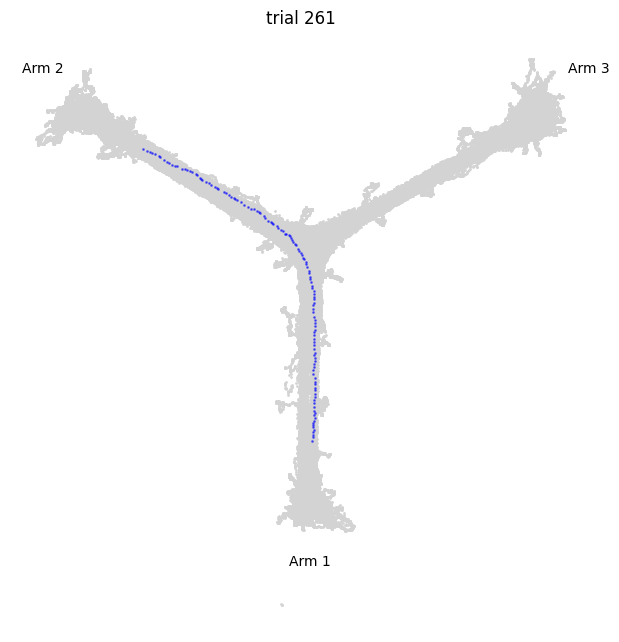

In [3]:
turn_id_tmp = 261

pos_start_index = turn_df['pre_turn_start_index'].iloc[turn_id_tmp]
pos_stop_index = turn_df['post_turn_stop_index'].iloc[turn_id_tmp]

# Extract x and y positions
x = position_df['actual_x_position'].values
y = position_df['actual_y_position'].values
x_tr = position_df['actual_x_position'].iloc[pos_start_index:pos_stop_index].values
y_tr = position_df['actual_y_position'].iloc[pos_start_index:pos_stop_index].values

# Rotate the points counter-clockwise by 120 degrees
rotated_x, rotated_y = rotate_points(x, y, -120)
rotated_x_tr, rotated_y_tr = rotate_points(x_tr, y_tr, -120)

# Plot the original and rotated points
plt.figure(figsize = (7.5,7.80)) 

plt.text(0.02, 0.95, 'Arm 2', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.96, 0.95, 'Arm 3', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.48, 0.13, 'Arm 1', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')

plt.scatter(rotated_x, rotated_y, color = 'lightgray', s = 1)
plt.scatter(rotated_x_tr, rotated_y_tr, color =  'b', s = 1, alpha= 0.5)
plt.title('trial ' + str(turn_id_tmp))
plt.gca().invert_yaxis()
plt.axis('off');

- Now, how can we look at its hippocampal activity during this trial? To start, we need to linearize the position of the animal to then overlay the neural activity.

### Linearize 2D trajectory and plot it over time (left turn trial)
- The blue line is the linearized data of the mouse's actual position over time. This will come in handy in the next step when we look at its relationship to the decoded position from the hippocampus.
- Note that the animal's actual position still goes from Arm 1 (linearized position 0-45 cm) to Arm 2 (linearized position 45-90 cm). Arm boundaries are denoted by the horizontal dashed lines.

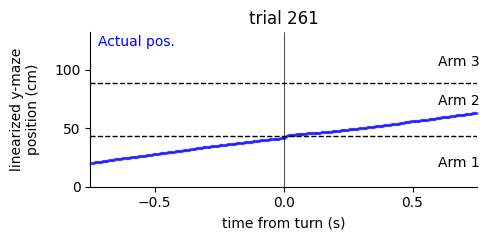

In [4]:
matplotlib.rcParams.update({'font.size':10})
    
fig, (ax1) = plt.subplots(figsize = (5,2.5))

pre_dur = 1
post_dur = 1
offset = 0.25
pix2cm_fac = 45.5 / 475 #cm per pixel

turn_time = turn_df['turn_time'][turn_id_tmp]
start_s = turn_time - pre_dur
stop_s = turn_time + post_dur
start_s_plot = start_s + offset - turn_time
stop_s_plot = stop_s - offset - turn_time

turn = turn_id_tmp
turn_time_dur_idx = np.where((results.time > turn_df.iloc[turn_id_tmp].turn_time - pre_dur + offset) & (results.time < turn_df.iloc[turn_id_tmp].turn_time + post_dur - offset))[0]
turn_time = turn_df.iloc[turn_id_tmp].turn_time
turn_dir = turn_df.iloc[turn_id_tmp].turn_id

Linear_position_test_concat_tr = Linear_position_test_concat[turn_time_dur_idx] * pix2cm_fac
jump_idx = np.where(nonlocal_jumps['turn_id'] == turn_id_tmp)[0]

if decode_output_type == 'acausal':
    posterior = results.acausal_posterior[turn_time_dur_idx]
elif decode_output_type == 'causal':
    posterior = results.causal_posterior[turn_time_dur_idx]
posterior["adjusted_time"] = posterior["time"] - turn_time
tmin = posterior["adjusted_time"][0].values
tmax = posterior["adjusted_time"][-1].values

# plot decode
if decode_output_type == 'acausal':
    break_pos = results.acausal_posterior['position'][np.argwhere(np.isnan(results.acausal_posterior[0].values)).flatten()].values
elif decode_output_type == 'causal':
    break_pos = results.causal_posterior['position'][np.argwhere(np.isnan(results.acausal_posterior[0].values)).flatten()].values

# plot actual and indicate jump times
ax1.scatter(posterior.adjusted_time.values, Linear_position_test_concat_tr, color='b', s=2, clip_on=False, alpha=0.1)
ax1.axvline(x=0, color='k', linewidth = 0.5)
ax1.set_xlim(start_s_plot, stop_s_plot)
ax1.set_ylim(0, posterior.position[-1].values)
ax1.axhline(y=break_pos[0], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=break_pos[1], color='k', linestyle='--', linewidth=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('linearized y-maze\nposition (cm)', labelpad = 10)
ax1.set_xlabel('time from turn (s)');
ax1.set_xticks([-0.5, 0, 0.5])
ax1.set_title('trial ' + str(turn_id_tmp))

ax1.text(0.02, 0.98, 'Actual pos.', color='b', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.9, 0.85, 'Arm 3', color='k', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.9, 0.6, 'Arm 2', color='k', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.9, 0.2, 'Arm 1', color='k', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')

plt.tight_layout()

### Overlay hippocampal decode (left turn trial with left sweep)
- Now we overlay the hippocampal decode and compare the animal's actual position over time in blue with it's decoded position from hippocampal activity in black (displayed as a probability distribution over all positions per time bin).
- The first thing to notice is that the decoded position tracks the actual position quite well but consists of these rhythmic forward 'sweeps' of activity (the upward black deflections). As the mouse approahes the bifurcation of the maze (time 0) these sweeps can extend ahead of the animal into the other arms. 
- Notice the forward 'sweep' of the decoded position (black smudge) up into Arm 2 (to the left) at the time when the mouse (blue line) is still in Arm 1! This is an example of a left turn with a left hippocampal sweep.

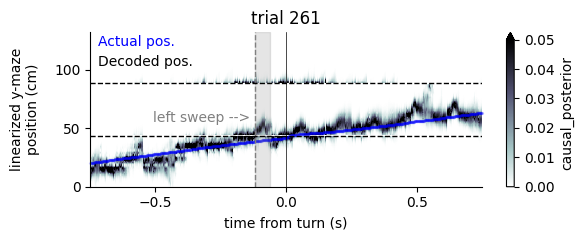

In [5]:
matplotlib.rcParams.update({'font.size':10})
    
fig, (ax1) = plt.subplots(figsize = (6,2.5))

turn_time = turn_df['turn_time'][turn_id_tmp]
start_s = turn_time - pre_dur
stop_s = turn_time + post_dur
start_s_plot = start_s + offset - turn_time
stop_s_plot = stop_s - offset - turn_time

turn = turn_id_tmp
turn_time_dur_idx = np.where((results.time > turn_df.iloc[turn_id_tmp].turn_time - pre_dur + offset) & (results.time < turn_df.iloc[turn_id_tmp].turn_time + post_dur - offset))[0]
turn_time = turn_df.iloc[turn_id_tmp].turn_time
turn_dir = turn_df.iloc[turn_id_tmp].turn_id

Linear_position_test_concat_tr = Linear_position_test_concat[turn_time_dur_idx] * pix2cm_fac
jump_idx = np.where(nonlocal_jumps['turn_id'] == turn_id_tmp)[0]

if decode_output_type == 'acausal':
    posterior = results.acausal_posterior[turn_time_dur_idx]
elif decode_output_type == 'causal':
    posterior = results.causal_posterior[turn_time_dur_idx]
posterior["adjusted_time"] = posterior["time"] - turn_time
tmin = posterior["adjusted_time"][0].values
tmax = posterior["adjusted_time"][-1].values

# plot decode
if decode_output_type == 'acausal':
    break_pos = results.acausal_posterior['position'][np.argwhere(np.isnan(results.acausal_posterior[0].values)).flatten()].values
    mesh = posterior.plot(x="adjusted_time", y="position", ax=ax1, robust=True, cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
elif decode_output_type == 'causal':
    break_pos = results.causal_posterior['position'][np.argwhere(np.isnan(results.acausal_posterior[0].values)).flatten()].values
    mesh = posterior.plot(x="adjusted_time", y="position", ax=ax1, robust=True, cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)

# plot actual and indicate jump times
ax1.scatter(posterior.adjusted_time.values, Linear_position_test_concat_tr, color='b', s=2, clip_on=False, alpha=0.1)
for jump in range(0, len(jump_idx)):
    if nonlocal_jumps['jump_dir'][jump_idx[jump]] == 'L':
        ax1.axvspan(nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, nonlocal_jumps['stop_time_global'][jump_idx[jump]]-turn_time, alpha=0.2, color='gray')
        ax1.axvline(x = nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, color = 'gray', linestyle = '--', linewidth=1)
    elif nonlocal_jumps['jump_dir'][jump_idx[jump]] == 'R':
        ax1.axvspan(nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, nonlocal_jumps['stop_time_global'][jump_idx[jump]]-turn_time, alpha=0.2, color='gray')
        ax1.axvline(x = nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, color = 'gray', linestyle = '--', linewidth=1)
ax1.axvline(x=0, color='k', linewidth = 0.5)
ax1.set_xlim(start_s_plot, stop_s_plot)
ax1.set_ylim(0, posterior.position[-1].values)
ax1.axhline(y=break_pos[0], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=break_pos[1], color='k', linestyle='--', linewidth=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('linearized y-maze\nposition (cm)', labelpad = 10)
ax1.set_xlabel('time from turn (s)');
ax1.set_xticks([-0.5, 0, 0.5])
ax1.set_title('trial ' + str(turn_id_tmp))

ax1.text(0.02, 0.98, 'Actual pos.', color='b', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.02, 0.85, 'Decoded pos.', color='k', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.16, 0.49, 'left sweep -->', color='gray', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')

plt.tight_layout()

- Now let's look at a left turn trial with a *right* sweep

### Plot 2D trajectory of a left turn trial with right hippocampal sweep
- This plot is the animal's 2D trajectory on the maze for a different left turn trial still going from Arm 1 to Arm 2.
- We don't know it yet but this trial contains a hippomcampal sweep to the right.

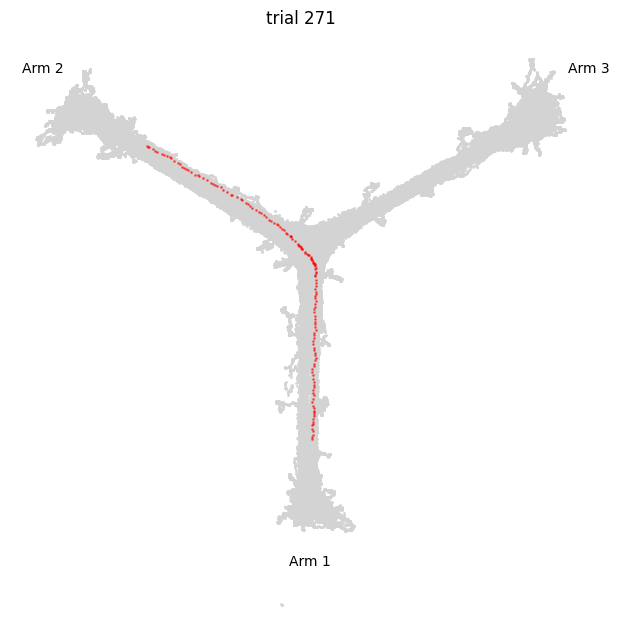

In [6]:
turn_id_tmp = 271

pos_start_index = turn_df['pre_turn_start_index'].iloc[turn_id_tmp]
pos_stop_index = turn_df['post_turn_stop_index'].iloc[turn_id_tmp]

# Extract x and y positions
x = position_df['actual_x_position'].values
y = position_df['actual_y_position'].values
x_tr = position_df['actual_x_position'].iloc[pos_start_index:pos_stop_index].values
y_tr = position_df['actual_y_position'].iloc[pos_start_index:pos_stop_index].values

# Rotate the points by 120 degrees
rotated_x, rotated_y = rotate_points(x, y, -120)
rotated_x_tr, rotated_y_tr = rotate_points(x_tr, y_tr, -120)

# Plot the original and rotated points
plt.figure(figsize = (7.5,7.80)) 

plt.text(0.02, 0.95, 'Arm 2', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.96, 0.95, 'Arm 3', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.48, 0.13, 'Arm 1', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')

plt.scatter(rotated_x, rotated_y, color = 'lightgray', s = 1)
plt.scatter(rotated_x_tr, rotated_y_tr, color =  'r', s = 1, alpha = 0.5)
plt.title('trial ' + str(turn_id_tmp))
plt.gca().invert_yaxis()
plt.axis('off');

### Plot single trial decode of a left turn trial with right hippocampal sweep
- Now we linearize the 2D trajectory for this left turn trial (now with *right* sweep) and overlay the hippocampal decode.
- Notice the forward sweep of the decoded position but now up into Arm 3 while the mouse (red line) is still in Arm 1. This is an example of a left turn trial with a right hippocampal sweep.

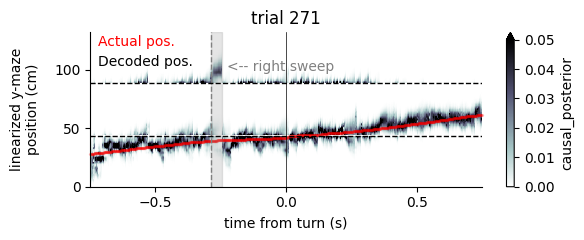

In [7]:
turn_id_tmp = 271 
    
fig, (ax1) = plt.subplots(figsize = (6,2.5))

turn_time = turn_df['turn_time'][turn_id_tmp]
start_s = turn_time - pre_dur
stop_s = turn_time + post_dur
start_s_plot = start_s + offset - turn_time
stop_s_plot = stop_s - offset - turn_time

turn = turn_id_tmp
turn_time_dur_idx = np.where((results.time > turn_df.iloc[turn_id_tmp].turn_time - pre_dur + offset) & (results.time < turn_df.iloc[turn_id_tmp].turn_time + post_dur - offset))[0]
turn_time = turn_df.iloc[turn_id_tmp].turn_time
turn_dir = turn_df.iloc[turn_id_tmp].turn_id

Linear_position_test_concat_tr = Linear_position_test_concat[turn_time_dur_idx] * pix2cm_fac
jump_idx = np.where(nonlocal_jumps['turn_id'] == turn_id_tmp)[0]

if decode_output_type == 'acausal':
    posterior = results.acausal_posterior[turn_time_dur_idx]
elif decode_output_type == 'causal':
    posterior = results.causal_posterior[turn_time_dur_idx]
posterior["adjusted_time"] = posterior["time"] - turn_time
tmin = posterior["adjusted_time"][0].values
tmax = posterior["adjusted_time"][-1].values

# plot decode
if decode_output_type == 'acausal':
    break_pos = results.acausal_posterior['position'][np.argwhere(np.isnan(results.acausal_posterior[0].values)).flatten()].values
    mesh = posterior.plot(x="adjusted_time", y="position", ax=ax1, robust=True, cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)
elif decode_output_type == 'causal':
    break_pos = results.causal_posterior['position'][np.argwhere(np.isnan(results.acausal_posterior[0].values)).flatten()].values
    mesh = posterior.plot(x="adjusted_time", y="position", ax=ax1, robust=True, cmap="bone_r", vmin=0.0, vmax=0.05, clip_on=False)

# plot actual and indicate jump times
ax1.scatter(posterior.adjusted_time.values, Linear_position_test_concat_tr, color='r', s=2, clip_on=False, alpha=0.1)
for jump in range(0, len(jump_idx)):
    if nonlocal_jumps['jump_dir'][jump_idx[jump]] == 'L':
        ax1.axvspan(nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, nonlocal_jumps['stop_time_global'][jump_idx[jump]]-turn_time, alpha=0.2, color='gray')
        ax1.axvline(x = nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, color = 'gray', linestyle = '--', linewidth=1)
    elif nonlocal_jumps['jump_dir'][jump_idx[jump]] == 'R':
        ax1.axvspan(nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, nonlocal_jumps['stop_time_global'][jump_idx[jump]]-turn_time, alpha=0.2, color='gray')
        ax1.axvline(x = nonlocal_jumps['start_time_global'][jump_idx[jump]]-turn_time, color = 'gray', linestyle = '--', linewidth=1)
ax1.axvline(x=0, color='k', linewidth = 0.5)
ax1.set_xlim(start_s_plot, stop_s_plot)
ax1.set_ylim(0, posterior.position[-1].values)
ax1.axhline(y=break_pos[0], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=break_pos[1], color='k', linestyle='--', linewidth=1)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('linearized y-maze\nposition (cm)', labelpad = 10)
ax1.set_xlabel('time from turn (s)');
ax1.set_xticks([-0.5, 0, 0.5])
ax1.set_title('trial ' + str(turn_id_tmp))

ax1.text(0.02, 0.98, 'Actual pos.', color='r', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.02, 0.85, 'Decoded pos.', color='k', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')
ax1.text(0.35, 0.82, '<-- right sweep', color='gray', transform=ax1.transAxes,
         fontsize=10, va='top', ha='left')

plt.tight_layout()

- Now let us visually compare these trajectories by overlaying them. Does sweep direction predict changes in the animal's trajectory?
- Shown below is an overlay of both 2D trajectories on the same maze outline. Note that the animal’s trajectory during the left turn trial with left sweep is slightly tighter (closer to the inside of the turn) than the left turn trial with a right sweep.

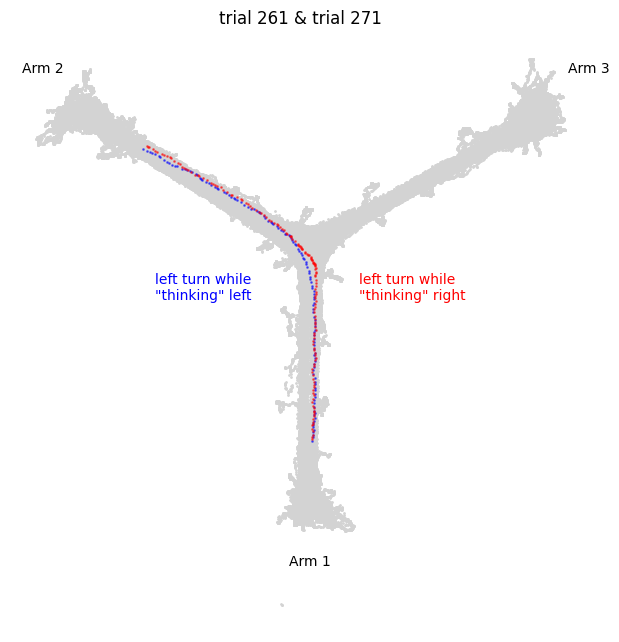

In [8]:
turn_id_tmp1 = 261

pos_start_index1 = turn_df['pre_turn_start_index'].iloc[turn_id_tmp1]
pos_stop_index1 = turn_df['post_turn_stop_index'].iloc[turn_id_tmp1]

# Extract x and y positions
x = position_df['actual_x_position'].values
y = position_df['actual_y_position'].values
x_tr1 = position_df['actual_x_position'].iloc[pos_start_index1:pos_stop_index1].values
y_tr1 = position_df['actual_y_position'].iloc[pos_start_index1:pos_stop_index1].values

# Rotate the points by 120 degrees
rotated_x, rotated_y = rotate_points(x, y, -120)
rotated_x_tr1, rotated_y_tr1 = rotate_points(x_tr1, y_tr1, -120)

turn_id_tmp2 = 271

pos_start_index2 = turn_df['pre_turn_start_index'].iloc[turn_id_tmp2]
pos_stop_index2 = turn_df['post_turn_stop_index'].iloc[turn_id_tmp2]

# Extract x and y positions
x_tr2 = position_df['actual_x_position'].iloc[pos_start_index2:pos_stop_index2].values
y_tr2 = position_df['actual_y_position'].iloc[pos_start_index2:pos_stop_index2].values

# Rotate the points by 120 degrees
rotated_x_tr2, rotated_y_tr2 = rotate_points(x_tr2, y_tr2, -120)

# Plot the original and rotated points
plt.figure(figsize = (7.5,7.80)) 

plt.text(0.02, 0.95, 'Arm 2', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.96, 0.95, 'Arm 3', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.48, 0.13, 'Arm 1', color='k',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.25, 0.60, 'left turn while\n"thinking" left', color='b',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.6, 0.60, 'left turn while\n"thinking" right', color='r',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')

plt.scatter(rotated_x, rotated_y, color = 'lightgray', s = 1)
plt.scatter(rotated_x_tr1, rotated_y_tr1, color =  'b', s = 1, alpha= 0.5)
plt.scatter(rotated_x_tr2, rotated_y_tr2, color =  'r', s = 1, alpha= 0.5)
plt.title('trial ' + str(turn_id_tmp1) + ' & trial ' + str(turn_id_tmp2))
plt.gca().invert_yaxis()
plt.axis('off');

- As evident in the trajectory overlay plot, we observe slight deviations for a given turn direction depending on the direction of the preceding hippocampal sweep! How might we quantify this?
- In the plots below, I first calculated the average trajectory across all left turn trials for this session (~250 left turns) depending on sweep direction (left vs. right).

In [9]:
# create dataframe turn id and sweep direction, sweep (jump) direction and turn direction
turn_jump_dir = nonlocal_jumps[['turn_id', 'jump_dir']].copy()
turn_jump_dir['turn_dir'] = ''
# Assign 'L' to left turns and 'R' to right turns
left_mask = turn_jump_dir['turn_id'].map(lambda tid: turn_df.loc[tid, 'turn_id'] == 'left')
turn_jump_dir.loc[left_mask, 'turn_dir'] = 'L'
right_mask = turn_jump_dir['turn_id'].map(lambda tid: turn_df.loc[tid, 'turn_id'] == 'right')
turn_jump_dir.loc[right_mask, 'turn_dir'] = 'R'
left_turn_dirs = np.where(turn_df['turn_id'].iloc[turn_jump_dir['turn_id']] == 'left')[0]

# for left turns get indexes of non_local jumps for right and left
right_jumps_left_turns = np.where(turn_jump_dir['jump_dir'].iloc[left_turn_dirs] == 'R')[0]
left_jumps_left_turns = np.where(turn_jump_dir['jump_dir'].iloc[left_turn_dirs] == 'L')[0]

# get ipsilateral and contralateral sweeps 
right_sweeps = nonlocal_jumps.iloc[left_turn_dirs[right_jumps_left_turns]].reset_index(drop=True)
left_sweeps = nonlocal_jumps.iloc[left_turn_dirs[left_jumps_left_turns]].reset_index(drop=True)
LTRS_id = np.unique(right_sweeps['turn_id'])
LTLS_id = np.unique(left_sweeps['turn_id'])
LT_intersect = np.intersect1d(LTLS_id, LTRS_id)
LTRS_id = np.setdiff1d(LTRS_id, LT_intersect)
LTLS_id = np.setdiff1d(LTLS_id, LT_intersect)

# get trajectories
# ipsi
turn_sweep_type = LTLS_id
x_pos_test_rotated_ipsi, y_pos_test_rotated_ipsi, pos_time_test_ipsi = get_rotated_traj(turn_sweep_type)
x_pos_test_rotated_ipsi, y_pos_test_rotated_ipsi, LTLS_id_curated  = curate_beh_trials(x_pos_test_rotated_ipsi, y_pos_test_rotated_ipsi, turn_sweep_type)
traj_ipsi_x_all, avg_traj_ipsi_x, traj_ipsi_y_all, avg_traj_ipsi_y = get_avg_trajectory(x_pos_test_rotated_ipsi, y_pos_test_rotated_ipsi)
# contra
turn_sweep_type = LTRS_id
x_pos_test_rotated_contra, y_pos_test_rotated_contra, pos_time_test_contra = get_rotated_traj(turn_sweep_type)
x_pos_test_rotated_contra, y_pos_test_rotated_contra, LTRS_id_curated  = curate_beh_trials(x_pos_test_rotated_contra, y_pos_test_rotated_contra, turn_sweep_type)
traj_contra_x_all, avg_traj_contra_x, traj_contra_y_all, avg_traj_contra_y = get_avg_trajectory(x_pos_test_rotated_contra, y_pos_test_rotated_contra)

# normalize trajectories
(
    traj_ipsi_x_all, avg_traj_ipsi_x,
    traj_ipsi_y_all, avg_traj_ipsi_y,
    traj_contra_x_all, avg_traj_contra_x,
    traj_contra_y_all, avg_traj_contra_y
) = normalize_trajectories(
    traj_ipsi_x_all, avg_traj_ipsi_x,
    traj_ipsi_y_all, avg_traj_ipsi_y,
    traj_contra_x_all, avg_traj_contra_x,
    traj_contra_y_all, avg_traj_contra_y
)

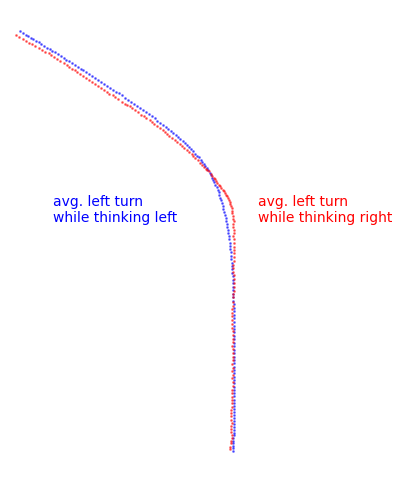

In [10]:
plt.figure(figsize=(4,6))

plt.scatter(avg_traj_ipsi_x, avg_traj_ipsi_y, s = 1, color = 'b', alpha = 0.5)
plt.scatter(avg_traj_contra_x, avg_traj_contra_y, s = 1, color = 'r', alpha = 0.5)

plt.text(0.14, 0.60, 'avg. left turn\nwhile thinking left', color='b',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.8, 0.60, 'avg. left turn\nwhile thinking right', color='r',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')

plt.gca().invert_yaxis()
plt.xlim(200,600)
plt.axis('off');

- Next, I define a region of interest around the center point of the maze where the deviations are most prominent

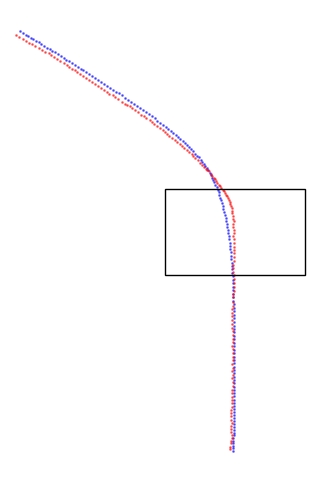

In [11]:
# Region of interest
x_trunc_limits = [400, 580]
y_trunc_limits = [350, 450]

plt.figure(figsize=(4,6))

plt.scatter(avg_traj_ipsi_x, avg_traj_ipsi_y, s = 1, color = 'b', alpha = 0.5)
plt.scatter(avg_traj_contra_x, avg_traj_contra_y, s = 1, color = 'r', alpha = 0.5)

# make a rectangle
rect = plt.Rectangle(
    (x_trunc_limits[0], y_trunc_limits[0]),
    x_trunc_limits[1] - x_trunc_limits[0],
    y_trunc_limits[1] - y_trunc_limits[0],
    fill=False,
    color='k',
    linewidth=1
)
plt.gca().add_patch(rect)

plt.gca().invert_yaxis()
plt.xlim(200,600)
plt.axis('off');

- Lastly, using this region of interest, I defined a line that intersected two points: one at the average between where the trajectories meet the top of the region of interest, and another where they meet the bottom.

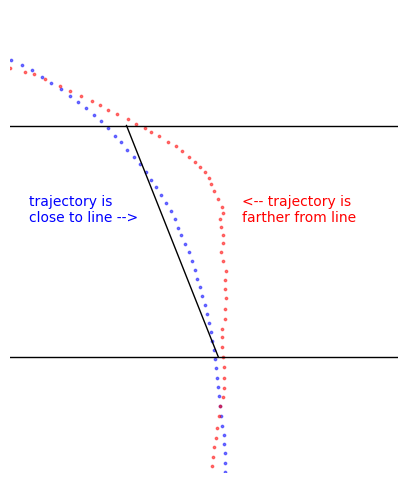

In [12]:
# truncate trajectories based on ROI and get X points from the averages for point to point distance analysis
truncated_contra_x, truncated_contra_y = truncate_trajectories(x_trunc_limits, y_trunc_limits, avg_traj_contra_x, avg_traj_contra_y)
truncated_ipsi_x, truncated_ipsi_y = truncate_trajectories(x_trunc_limits, y_trunc_limits, avg_traj_ipsi_x, avg_traj_ipsi_y)
(
    x1, x2, 
    y1, y2
) = get_truncated_x_points(
    truncated_ipsi_x, 
    truncated_ipsi_y, 
    truncated_contra_x, 
    truncated_contra_y, 
    x_trunc_limits, 
    y_trunc_limits
)

plt.figure(figsize=(5,6))

plt.scatter(avg_traj_ipsi_x, avg_traj_ipsi_y, s = 3, color = 'b', alpha = 0.5)
plt.scatter(avg_traj_contra_x, avg_traj_contra_y, s = 3, color = 'r', alpha = 0.5)

# make a rectangle
rect = plt.Rectangle(
    (x_trunc_limits[0], y_trunc_limits[0]),
    x_trunc_limits[1] - x_trunc_limits[0],
    y_trunc_limits[1] - y_trunc_limits[0],
    fill=False,
    color='k',
    linewidth=1
)
plt.gca().add_patch(rect)

plt.text(0.05, 0.60, 'trajectory is\nclose to line -->', color='b',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')
plt.text(0.6, 0.60, '<-- trajectory is\nfarther from line', color='r',
         fontsize=10, transform=plt.gca().transAxes,
         va='top', ha='left')


plt.gca().invert_yaxis()
plt.plot([x1,x2], [y1,y2], color = 'k', linewidth = 1)
plt.xlim(450,520)
plt.ylim(500,300)
plt.axis('off');

- We can then calculate point to point distances from this line to a trajectory of interest.
- If the trajectories are completely overlapping, the distances between this line and each trajectory will be the same. If they are distinct, these distances will be different.
- In the vast majority of sessions, for a given turn direction, trials that contain sweeps in the direction of the turn have lower distances to this line (i.e., are tighter) than those that contain sweeps in the opposite direction.

### What might this all mean?
- Essentially, when a mouse thinks about going one way vs. the other way this can be read out by subtle deflections in its behavior, as if it were 'deliberating' through its movements. Thus, mice can't hide their thoughts!
- Interestingly, this occurs in coordination with the 'turning' center in the brain, the superior colliculus, which is the other main part of my thesis project.